In [2]:
from keras_segmentation.models.unet import vgg_unet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import imgaug as ia
import imgaug.augmenters as iaa

In [7]:
data = pd.read_csv('data.csv')
data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,1280,428,1280,882,26,872,2,img00.jpg,1
2,353,109,3465,141,3489,481,345,481,1,img01.jpg,1
3,329,533,3493,521,3569,1633,317,1781,2,img01.jpg,1
4,121,673,3869,633,3909,1057,105,1117,1,img02.jpg,1


In [12]:
for f in data.fname.unique():
    img = cv2.imread('data/'+f)
    seg = cv2.imread('annotations/'+f.split('.')[0]+'.png')
    img_r = cv2.resize(img, (224,224))
    seg_r = cv2.resize(seg, (224,224))
    cv2.imwrite('images_train_2/'+f.split('.')[0]+'.png',img_r)
    cv2.imwrite('annotations_train_2/'+f.split('.')[0]+'.png',seg_r)

In [9]:
def augment_seg(img,seg,seq):
    aug_det = seq.to_deterministic()
    image_aug = aug_det.augment_image(img)
    segmap = ia.SegmentationMapOnImage(seg, nb_classes=np.max(seg)+1, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr_int()
    return image_aug, segmap_aug

def augmentation_images(images,annotations):
    """
    images = glob.glob('images_train_2/*.png')
    annotations = glob.glob('annotations_train_2/*.png')
    """
    
    img_path = images[0].split('/')[0]
    annot_path = annotations[0].split('/')[0]
    for i,s in zip(images,annotations):
    
        fname = i.split('/')[-1].split('.')[0]
        img = cv2.imread(i)
        seg = cv2.imread(s)

        for n in range(20):

            # crop augmentation
            bnds = np.random.randint(5,40,4)
            seq_crop = iaa.Sequential([iaa.Crop(px=tuple(bnds))])
            img_aug, seg_aug = augment_seg(img,seg,seq_crop)
            cv2.imwrite( img_path + '/'+fname+'_crop'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_crop'+str(n)+'.png',seg_aug)

            # rotate augmentation
            seq_rotate = iaa.Sequential([iaa.Affine(rotate=(-10,10))])
            img_aug, seg_aug = augment_seg(img,seg,seq_rotate)
            cv2.imwrite(img_path+'/'+fname+'_rotate'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_rotate'+str(n)+'.png',seg_aug)

            # scale augmentation
            seq_scale = iaa.Sequential([iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})])
            img_aug, seg_aug = augment_seg(img,seg,seq_scale)
            cv2.imwrite(img_path+'/'+fname+'_scale'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_scale'+str(n)+'.png',seg_aug)

            # blur augmentation
            seq_blur = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 3.0))])
            img_aug, seg_aug = augment_seg(img,seg,seq_blur)
            cv2.imwrite(img_path+'/'+fname+'_blur'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_blur'+str(n)+'.png',seg_aug)

In [13]:
images = glob.glob('images_train_2/*.png')
annotations = glob.glob('annotations_train_2/*.png')
augmentation_images(images,annotations)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Method `SegmentationMapsOnImage.get_arr_int()` is deprecated. Use `SegmentationMapsOnImage.get_arr()` instead.
  warn_deprecated(msg, stacklevel=3)


In [14]:
# create validation dataset
!mv images_train_2/img04*.png validation_2/
!mv images_train_2/img09*.png validation_2/
!mv annotations_train_2/img04*.png annotation_validation_2/
!mv annotations_train_2/img09*.png annotation_validation_2/

In [15]:
from keras_segmentation import models

In [16]:
from keras_segmentation.models import unet

In [19]:
model_2 = unet.mobilenet_unet(n_classes=4, input_height=224, input_width=224)

In [20]:
model_2.train(
    train_images =  "images_train_2/",
    train_annotations = "annotations_train_2/",
    validate = True,
    val_images = "validation_2/",
    val_annotations = "annotation_validation_2/",
    epochs=5
)

  8%|▊         | 55/648 [00:00<00:01, 544.26it/s]

Verifying training dataset


 33%|███▎      | 53/162 [00:00<00:00, 527.39it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 162/162 [00:00<00:00, 529.06it/s]

Dataset verified! 
Starting Epoch  0
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
512/512 [==============================] - 57s 112ms/step - loss: 0.1152 - accuracy: 0.9640 - val_loss: 0.0613 - val_accuracy: 0.9705
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.0575 - val_accuracy: 0.9739
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0610 - val_accuracy: 0.9621
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0103 - accuracy: 0.9964 - val_loss: 0.3405 - val_accuracy: 0.9404
Finished Epoch 3
Starting Epoch  4
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0692 - val_accuracy: 0.9686
Finished Epoch 4


In [21]:
model_2.save('segm_mob_224_224.h5')

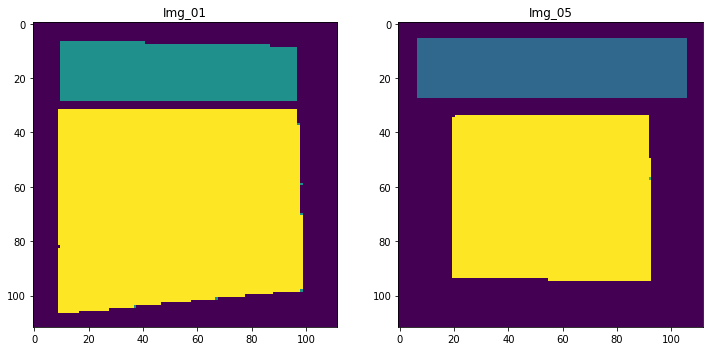

In [23]:
out_1 = model_2.predict_segmentation(inp="images_train_2/img01.png")
out_2 = model_2.predict_segmentation(inp="images_train_2/img05.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Img_01')
plt.imshow(out_1)
plt.subplot(1,2,2)
plt.title('Img_05')
plt.imshow(out_2)

In [24]:
for f in ['test_1.jpg', 'test_2.jpg']:
    img = cv2.imread('test_img/'+f)
    img_r = cv2.resize(img, (224,224))
    cv2.imwrite('test_img/'+'mob_'+f.split('.')[0]+'.png',img_r)

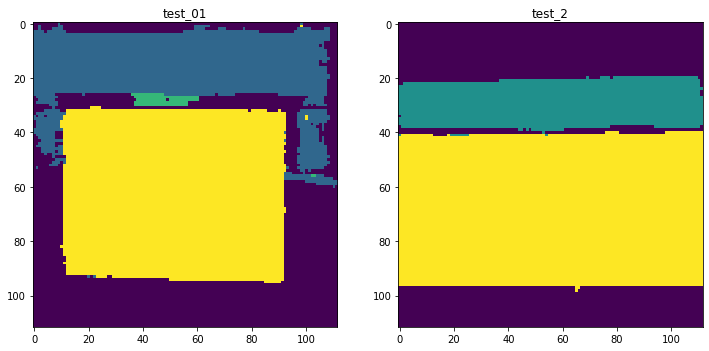

In [25]:
test_1 = model_2.predict_segmentation(inp="test_img/mob_test_1.png")
test_2 = model_2.predict_segmentation(inp="test_img/mob_test_2.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('test_01')
plt.imshow(test_1)
plt.subplot(1,2,2)
plt.title('test_2')
plt.imshow(test_2)

In [37]:
test_1.shape

(208, 304)